In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# path = '/global/homes/e/ecastori/PostBorn/'
path = '../PostBornEma/'

In [4]:
data = np.loadtxt(path+'FFT_k-1Pk.dat',skiprows=2)

#----------------------#
n         = data[:,0]
Re_c_n    = data[:,1]
Im_c_n    = data[:,2]
Re_nu_n   = data[:,3]
Im_nu_n   = data[:,4]
#----------------------#

c_n  = Re_c_n  + 1j * Im_c_n
nu_n = Re_nu_n + 1j * Im_nu_n

In [5]:
# ## When reading Ema's files for the first time

# data = np.loadtxt(path+'Il_nu_t_nd4.dat',skiprows=1)
# # data = np.loadtxt(path+'Il_nu_t.dat',skiprows=1)

# #----------------------#
# ell       = data[:,0]
# nn        = data[:,1]
# tt        = data[:,2]
# Re_I      = data[:,3]
# Im_I      = data[:,4]
# #----------------------#

# I_ = Re_I + 1j * Im_I

# # np.save('../PostBornEma/Il_nu_t_new1-ell-nn-tt', np.stack((ell, nn, tt), axis=1))
# # np.save('../PostBornEma/Il_nu_t_new1-ReI-ImI', np.stack((Re_I, Im_I), axis=1))

In [6]:
data =  np.load(path+'Il_nu_t_new1-ell-nn-tt.npy')
ell       = data[:,0]
nn        = data[:,1]
tt        = data[:,2]
#----------------------#

data =  np.load(path+'Il_nu_t_new1-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_0 = Re_I + 1j * Im_I


In [7]:
# data =  np.load(path+'Il_nu_t_nd2-ell-nn-tt.npy')
# ell2       = data[:,0]
# nn2       = data[:,1]
# tt2        = data[:,2]
#----------------------#

data =  np.load(path+'Il_nu_t_nd2-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_2 = Re_I + 1j * Im_I

data =  np.load(path+'Il_nu_t_nd4-ReI-ImI.npy')
Re_I      = data[:,0]
Im_I      = data[:,1]
#----------------------#

I_4 = Re_I + 1j * Im_I



In [8]:
del Re_I, Im_I, data

In [9]:
ell_ = np.unique(ell)
nu_n_= np.unique(nu_n) 
t_=np.unique(tt)

ell = ell.reshape(ell_.size, nu_n_.size, t_.size)
nn = nn.reshape(ell_.size, nu_n_.size, t_.size)
tt = tt.reshape(ell_.size, nu_n_.size, t_.size)
I_0 = I_0.reshape(ell_.size, nu_n_.size, t_.size)
I_2 = I_2.reshape(ell_.size, nu_n_.size, t_.size)
I_4 = I_4.reshape(ell_.size, nu_n_.size, t_.size)

cn2 = c_n.copy()
cn2[:-1] *=2
I0_lcrt = np.expand_dims(I_0, 2)*cn2.reshape(1, -1, 1, 1)
I2_lcrt = np.expand_dims(I_2, 2)*cn2.reshape(1, -1, 1, 1)
I4_lcrt = np.expand_dims(I_4, 2)*cn2.reshape(1, -1, 1, 1)

I0_ltrc = np.swapaxes(I0_lcrt, 1, 3)
I2_ltrc = np.swapaxes(I2_lcrt, 1, 3)
I4_ltrc = np.swapaxes(I4_lcrt, 1, 3)


In [10]:
data = np.loadtxt(path+'GG_weights.dat',skiprows=2)
t1   = data[:,0]
w1   = data[:,1]
assert(np.allclose(t_,t1))


In [11]:
print((np.unique(tt)-t1)/t1)

[ 2.30548984e-08  2.65243249e-10  1.78144134e-08 -5.52722206e-09
 -3.81277301e-09  5.83037597e-09 -2.16307397e-08  8.21517625e-09
 -6.99181363e-09 -1.99569546e-08 -2.50249677e-09  1.43903302e-08
 -1.78592624e-09 -1.07727314e-08 -9.38352570e-09  5.21967604e-09
 -3.73175222e-09  7.99810927e-10  7.18924032e-10 -1.84171278e-09
  3.74196032e-08 -4.31708834e-08  5.77553278e-09 -3.72380153e-08
  8.43105523e-09  1.95534766e-09  1.33447784e-08 -2.43461846e-08
 -5.29954192e-10  2.43688638e-08  1.73100201e-08  1.76443481e-08
  4.16803916e-10 -1.81535039e-08 -1.83445586e-08 -3.91387615e-09
  1.42272881e-08 -2.58428395e-09 -9.87332093e-09 -5.90284222e-09
 -1.13092936e-08 -5.42437739e-10 -2.34467351e-09 -5.01121171e-09
 -7.23833552e-10  3.25658320e-09 -4.04126215e-09 -3.03710215e-09
 -2.51802399e-09 -4.46985937e-09  4.33229064e-09  2.29254456e-09
  2.59723738e-09  3.24561387e-09 -2.45570258e-09  5.12347394e-10
  3.32836881e-09  1.46068028e-09  3.16809597e-10  6.18899402e-09
  3.02489419e-09  4.73446

In [12]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)

# speed of light
c      = 299792458./1000. # km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [13]:
from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]
class_D               = cosmo_b['gr.fac. D'][::-1]#/cosmo_b['gr.fac. D'][-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']


from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = interp1d(class_z,class_chi*h, bounds_error=False, fill_value=0)
z_chi = interp1d(class_chi*h,class_z, bounds_error=False, fill_value=0)   # Mpc/h
D_chi = interp1d(class_chi*h,class_D, bounds_error=False, fill_value=0)    # growth
D_z   = interp1d(class_z,class_D, bounds_error=False, fill_value=0)
# chi_cmb
chi_cmb = chi_z(z_cmb)



In [14]:
print(chi_z(1100),chi_z(z_cmb))

9416.06644934157 9414.597956961135


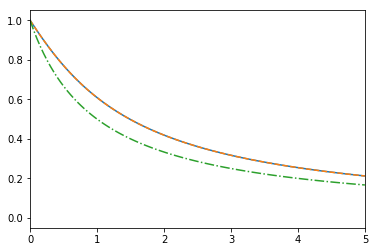

array(1.)

In [15]:
z = np.linspace(0,5,100)
plt.figure()
plt.plot(class_z,class_D,ls='-')
plt.plot(z,D_z(z),ls='--')
plt.plot(z,1/(1+z),ls='-.')
plt.xlim(0,5)
plt.show()
D_z(0)

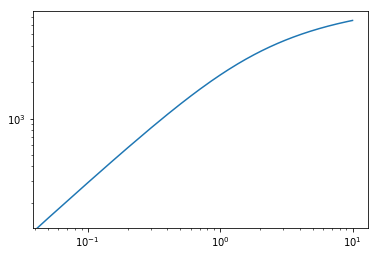

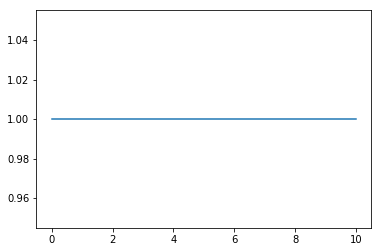

In [16]:
z=np.linspace(0.,10,200)
plt.figure()
plt.loglog(z,chi_z(z))
plt.show()
plt.figure()
plt.plot(z,D_z(z)/D_chi(chi_z(z)))
plt.show()
# plt.figure()
# plt.loglog(z,)
# plt.show()
# plt.figure()
# plt.loglog(z,z_chi(chi_z(z)))
# plt.show()

In [17]:
D_chi(chi_z(0.1))

array(0.94886829)

# Integrals here

In [19]:
from scipy.integrate import simps, quadrature
from scipy.interpolate import interp1d
import time


In [20]:
### Try with the auto-spectra without symmetrizing so that we check the second term of Eq. 3.05
##Also, no need to estimate the kernels again and again since they are independent of \ell and \nu
##This way we reduce calls to interpolate and stuff
##Well, some things depend on \nu so Use \nu as the third axes so that all the \chi kernels can be estimated beforehand

def Wkernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
I0_ltrc = np.swapaxes(I0_lcrt, 1, 3)


begin=time.time()

chi1fac0 = (Wkernel(r2d*chi_cmb, chi_cmb)*D_chi(r2d*chi_cmb))
chi1fac0 = chi1fac0 *(r2d*chi_cmb)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb))
chi2fac01 = (Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1/t2d*chi_cmb))
chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I0_ltrc[ii])

Cl=chi_cmb * result*4./np.pi**2*prefac**2/8.

print('Time taken = ', time.time()-begin)

/home/chirag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  2.3071441650390625


We have integrals of the form (for example, take the second term of $C_{22shift}^{\kappa g}$ i.e. eq. 4.2; drop the integral over $\ell$):
<br>
\begin{eqnarray}
Target &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\Phi \Psi}(\chi', \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'} d\chi" W(\chi", \chi') C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Now,
\begin{eqnarray}
C_l^{ab}(\chi_1, \chi_2) &=& \int \frac{dk}{k} j_l(k\chi_1)j_l(k\chi_2) [k^3 P^{ab}(k, \chi_1, \chi_2)] \\
&=& \sum_n c_n \chi_1 ^{-\nu_n} I_l(\nu_n, \frac{\chi_2}{\chi_1})
\end{eqnarray}

So, 
\begin{eqnarray}
Target &=& \int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') \\
&\times& \Big(\int_0^{\chi'} d\chi" W(\chi", \chi') \sum_n c^{ab}_n \chi ^{-\nu_n} I_{l1}^{ab}(\nu_n, \frac{\chi''}{\chi}) \Big) \\
&\times& \Big(\int_0^{\chi} d\chi''' W(\chi''', \chi) \sum_n c^{cd}_n \chi' ^{-\nu_n} I_{l2}^{cd}(\nu_n, \frac{\chi'''}{\chi'}) \Big)
\end{eqnarray}

These are coupled together in complicated way amongst the 4 $\chi$. 
<br>
I think the best way to estimate these are to save the array - 
$$
\int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) 
$$
in the above above equation as a matrix $G(l, \chi, \chi')$.
<br>
This then reduces the evaluation of integrals to the sum - 
\begin{eqnarray}
Target &=& \int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') \times G^{ab}(l_1, \chi', \chi)\times G^{cd}(l_2, \chi, \chi')\\
\end{eqnarray}
which we can evaluate as a Gauss Qaud sum.

To save $G^{cd}(l_2, \chi, \chi')$, we have -

\begin{eqnarray}
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) \\
t &=& \chi ''/\chi' \\
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi/\chi'} dt W(t\chi', \chi) \sum_n c_n \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
G^{cd}(l, \chi, \chi') &=& \sum_n  \int_0^1 dt \big( c_n(\chi', t\chi') (W(t\chi', \chi) + t^{-\nu-2} c_n(\chi', \chi'/t) W(\chi'/t, \chi) \big) \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
\end{eqnarray}

__The problem here is that $t$ is fixed. And the obvious values of $\chi$ and $\chi'$ that we should take are $t \chi_{CMB}$. Hence I am a bit uncertain how well are we sampling this integral anymore in going from $\chi/\chi'$ to (0-1) limit. But it should work since that is what we do in the Cl_kk as well
__

In [21]:
### Estimate as function of 'chi' and then integrate over \chi
###This is a test to check that we can estimate Cl_kk with this accurately, which kind of justifies that we are estimating
###The G matrix accurately.

def Wkernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))


chimax = chi_cmb
chi1s = t_*chimax

chi1fac0 = (Wkernel(chi1s, chimax))#*D_chi(chi1s)) #Move this inside the sum

t2d = t_.reshape(1, -1, 1)
I0_ltc = np.squeeze(I0_ltrc)

begin = time.time()
result = []
for ii, chi in enumerate(chi1s):
    
    chifac = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop
    
    chi2fac00 = (Wkernel(t2d*chi, chimax)*D_chi(t2d*chi))
    chi2fac01 = (Wkernel(1/t2d*chi, chimax)*D_chi(1/t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
    chi2fac0 = chi2fac00 + chi2fac01
    fac = w1.reshape(1, -1, 1)*chi2fac0*chifac
    integrand = fac * I0_ltc
    result.append(integrand.sum(axis = (1, 2)))

result = np.array(result)
print(result.shape)
result = (result*chi1fac0.reshape(-1, 1)*w1.reshape(-1, 1)).sum(axis=0)
Cl2=chimax * result*4./np.pi**2*prefac**2/8.

print('Time taken = ', time.time()-begin)

(100, 289)
Time taken =  3.8490967750549316


In [22]:
# ### This works. This is same as above except needlessly fancy with evaluating \chi factors beforehand
# ### because I thought it will speed up things, but doesn't. oops. 

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))



# chimax = chi_cmb
# t2d = t_.reshape(1, -1, 1)
# r2d = t_.reshape(1, 1, -1)
# chi1s = t2d*chimax
# chi11d = t_*chimax

# chi1fac0 = (Wkernel(chi1s, chimax)*D_chi(chi1s))
# chi1nu = chi1s**(1-nu_n_.reshape(1, 1, -1))


# chi2fac00 = np.expand_dims(np.squeeze(Wkernel(t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*t2d*chi_cmb)), 2)
# chi2fac01 = np.expand_dims(np.squeeze(Wkernel(1/t2d*r2d*chi_cmb, chi_cmb)*D_chi(r2d*1/t2d*chi_cmb)), 2)
# chi2fac01 = chi2fac01 * t_.reshape(-1, 1, 1)**(nu_n_.reshape(1, 1, -1)-2)
# chi2fac0 = chi2fac00 + chi2fac01


# I_ltc = np.squeeze(I_ltrc)

# begin = time.time()
# result = []
# for ii, chi in enumerate(chi11d):
       
#     integrand = w1.reshape(1, -1, 1)*chi2fac0[:, ii]*chi1nu[0, ii] * I_ltc
#     result.append(integrand.sum(axis = (1, 2)))

# result = np.array(result)
# result = (result*chi1fac0.reshape(-1, 1)*w1.reshape(-1, 1)).sum(axis=0)
# Cl3=chimax * result*4./np.pi**2*prefac**2/8.

# print('Time taken = ', time.time()-begin)

/home/chirag/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(2, 500)

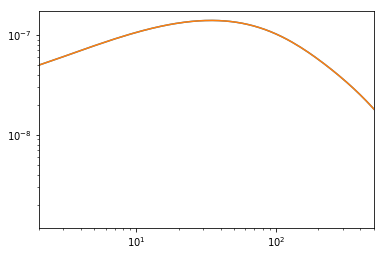

In [23]:
plt.figure()
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl[:lmax]/(2.*np.pi))
plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl2[:lmax]/(2.*np.pi))
# plt.loglog(ell_[:lmax],(ell_[:lmax]*(ell_[:lmax]+1.))**2*Cl3[:lmax]/(2.*np.pi))
plt.xlim(2,500)

/home/chirag/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


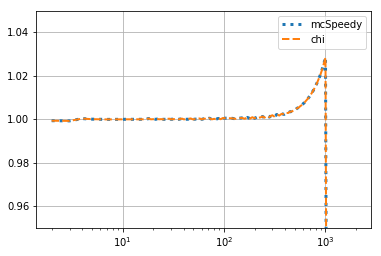

In [24]:
ll,clpp,clpp2 = np.loadtxt('class_ouput.out')

plt.figure()#
# plt.semilogx(ell_,Clv/np.interp(ell_,ll,clpp), label='nessa')
plt.semilogx(ell_,Cl/np.interp(ell_,ll,clpp), ls=":", lw=3, label='mcSpeedy')
plt.semilogx(ell_,Cl2/np.interp(ell_,ll,clpp), ls="--", lw=2, label='chi')
# plt.semilogx(ell_,Cl3/np.interp(ell_,ll,clpp), ls="-", lw=1, label='chi3')
plt.ylim(0.95,1.05)
# plt.ylim(0.9,2)
plt.grid()
plt.legend()

# save xifunc as described above

To save $G^{cd}(l_2, \chi, \chi')$, we have -

\begin{eqnarray}
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l(\nu_n, \frac{\chi''}{\chi'}) \\
t &=& \chi ''/\chi' \\
G^{cd}(l, \chi, \chi') &=& \int_0^{\chi/\chi'} dt W(t\chi', \chi) \sum_n c_n \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
G^{cd}(l, \chi, \chi') &=& \sum_n  \int_0^1 dt \big( c_n(\chi', t\chi') (W(t\chi', \chi) + t^{-\nu-2} c_n(\chi', \chi'/t) W(\chi'/t, \chi) \big) \chi' ^{1-\nu_n} I_l(\nu_n, t) \\
\end{eqnarray}

__The problem here is that $t$ is fixed. And the obvious values of $\chi$ and $\chi'$ that we should take are $t \chi_{CMB}$. Hence I am a bit uncertain how well are we sampling this integral anymore in going from $\chi/\chi'$ to (0-1) limit. But it should work since that is what we do in the Cl_kk as well
__

In [25]:
# ### Saving here

# def Wkernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi) * (1.+z_chi(xi))

# I4_ltc = np.squeeze(I4_ltrc)
# t2d = t_.reshape(1, -1, 1)

# chis = t_*chi_cmb
# chips = t_*chi_cmb

# Gsave = []

# begin = time.time()
# for ichim, chimax in enumerate(chis[:]):
#     if ichim %10 == 0:
#         print(ichim)
        
#     chi1fac0 = (Wkernel(chips, chimax))#*D_chi(chi1s)) #Move this inside the sum

#     result = []
#     for ii, chi in enumerate(chips):

#         chifac = chi**(1-nu_n_.reshape(1, 1, -1)) * D_chi(chi) #Move this c_n inside the loop

#         chi2fac00 = (Wkernel(t2d*chi, chimax)*D_chi(t2d*chi))
#         chi2fac01 = (Wkernel(1/t2d*chi, chimax)*D_chi(1/t2d*chi))* t2d**(nu_n_.reshape(1,  -1)-2)
#         chi2fac0 = chi2fac00 + chi2fac01
#         fac = w1.reshape(1, -1, 1)*chi2fac0*chifac
#         integrand = fac * I4_ltc
#         result.append(integrand.sum(axis = (1, 2)))

#     Gsave.append(np.array(result).T)
#     if ichim %10 == 0:
#         print(time.time()-begin)
    
# Gsave = np.swapaxes(np.array(Gsave), 0, 1)

# np.save(path + 'G-Ilnut_nd4', Gsave)

# Clgg

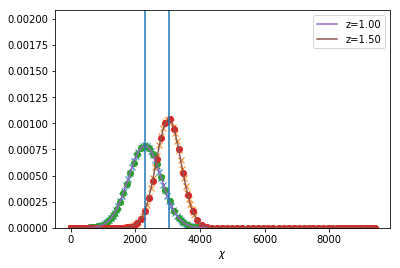

/home/chirag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  1.9029018878936768


/home/chirag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: ComplexWarning: Casting complex values to real discards the imaginary part


Time taken =  3.9377355575561523


In [28]:

############################# TAttempting Clgg here
##Also, no need to estimate the kernels again and again since they are independent of \ell and \nu
##This way we reduce calls to interpolate and stuff
##Well, some things depend on \nu so Use \nu as the third axes so that all the \chi kernels can be estimated beforehand

def Wgauss(xi, xi0, sigz=0.3):
    z0 = z_chi(xi0)
    z1, z2 = z0-sigz/2., z0+sigz/2.
    xi1, xi2 = chi_z(z1), chi_z(z2)
    sigxi = xi2-xi1
    return 1/np.sqrt(2*np.pi*sigxi**2) * np.exp(- (xi-xi0)**2/2/sigxi**2) 

# txi = np.linspace(1000, 5000, 100)
# plt.plot(t_*txi, Wgauss(t_*txi, chi_z(1)), '.')
# plt.plot(txi, Wgauss(txi, chi_z(1.5)))
# plt.plot(txi, Wgauss(txi, chi_z(1)))
# plt.axvline(chi_z(2.5))
# plt.axvline(chi_z(2))
# plt.yscale('log')

#########################################################################
#Set up

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)
I4_ltrc = np.swapaxes(I4_lcrt, 1, 3)
fudge = 4


#Redshift kernels

z10, z20, sigz = 1, 1.5, 0.15
chi10, chi20 = chi_z(z10), chi_z(z20)

#Make figure
plt.figure()
txi = np.linspace(0, chi_z(z20+5*sigz), 100)
plt.plot(t_*txi, Wgauss(t_*txi, chi_z(z10)), 'x')
plt.plot(t_*txi, Wgauss(t_*txi, chi_z(z20)), 'x')

txi = np.linspace(0, chi_cmb, 100)
plt.plot(t_*txi, Wgauss(t_*txi, chi_z(z10)), 'o')
plt.plot(t_*txi, Wgauss(t_*txi, chi_z(z20)), 'o')

plt.plot(txi, Wgauss(txi, chi_z(z10)), label='z=%0.2f'%z10)
plt.plot(txi, Wgauss(txi, chi_z(z20)), label='z=%0.2f'%z20)

plt.axvline(chi_z(z10))
plt.axvline(chi_z(z20))

plt.ylim( Wgauss(txi, chi_z(z10)).max()/1e5,  Wgauss(txi, chi_z(z20)).max()*2)
# plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.legend()
plt.show()


#########
begin=time.time()
#Try different chimax to see how sampling changes things
chimax = chi_z(z20+5*sigz)

chi1fac0 = (Wgauss(r2d*chimax, chi10, sigz)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (Wgauss(t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*t2d*chimax))
chi2fac01 = (Wgauss(1/t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clgg = chimax * result*4./np.pi**2/8.
Clgg /= fudge

print('Time taken = ', time.time()-begin)

###################################

chimax = chi_cmb

chi1fac0 = (Wgauss(r2d*chimax, chi10, sigz)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(4+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (Wgauss(t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*t2d*chimax))
chi2fac01 = (Wgauss(1/t2d*r2d*chimax, chi20, sigz)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((4+nu_n_).reshape(1, 1, -1)-2)
chi2fac0 = chi2fac00 + chi2fac01


chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Clggcmb = chimax * result*4./np.pi**2/8.
Clggcmb /= fudge

print('Time taken = ', time.time()-begin)


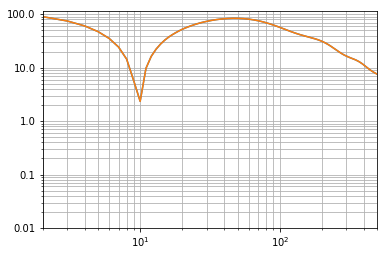

In [29]:
plt.plot(ell_, abs(Clgg)*1e9)
plt.plot(ell_, abs(Clggcmb)*1e9)
plt.loglog()
# plt.ylim(0.3, 25)
# plt.yticks((0.5, 1, 2, 5, 10), (0.5, 1, 2, 5, 10))
plt.yticks(np.logspace(-2, 2, 5), np.logspace(-2, 2, 5))
plt.xlim(2, 500)
plt.grid(which='both')

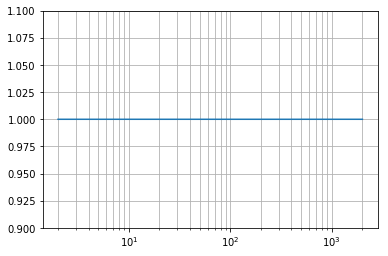

In [30]:
plt.plot(ell_, Clggcmb/Clgg)
plt.xscale('log')
plt.ylim(0.90, 1.1)
plt.grid(which='both')

# Integrals

\begin{eqnarray}
C_l^{ab}(\chi_1, \chi_2) &=& \int \frac{dk}{k} j_l(k\chi_1)j_l(k\chi_2) [k^3 P^{ab}(k, \chi_1, \chi_2)] \\
&=& \sum_n c_n \chi_1 ^{-\nu_n} I_l(\nu_n, \frac{\chi_2}{\chi_1})
\end{eqnarray}
(dropped 1/$4\pi$)

\begin{eqnarray}
G^{ab}(l, \chi, \chi') &=& \int_0^{\chi} d\chi" W(\chi", \chi) C_l^{ab}(\chi', \chi")  \\
&=&\int_0^{\chi} d\chi" W(\chi", \chi) \sum_n c_n \chi' ^{-\nu_n} I_l^{ab}(\nu_n, \frac{\chi''}{\chi'}) 
\end{eqnarray}
<br>


In the following, drop the integral over $\ell$

- $C_{22shift, A}^{\kappa g}$ i.e. eq. 4.2 second term :
<br>
\begin{eqnarray}
C_{22shift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here, we can create a table of ($\chi, \chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi', \chi''') $, then simply multiply with other $I_{l1}^{\delta \Psi}$ and do the remaining 2 integrals with GC
 

- $C_{22shift, B}^{\kappa g}$ i.e. eq. 4.2 second term :
<br>
\begin{eqnarray}
C_{22shift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\Phi \Psi}(\chi', \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'} d\chi" W(\chi", \chi') C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here, we can create use table of $G_{l_2, \chi, \chi'}^{\delta \Psi}$ and $G_{l_1, \chi, \chi'}^{\Psi \Psi}$, multiply them and then do the the remaining 2 integrals with GC

- $C_{13ashift, A}^{\kappa g}$ i.e. eq. 4.3 :
<br>
\begin{eqnarray}
C_{13ashift, A}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c)\int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi, \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 22A, we can create a table of ($\chi$) for the second half i.e. $\int_0^{\chi} d\chi" W(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\Psi \Psi}(\chi, \chi''') $, put it in the kernel of $\chi$; integrate out $\chi'$ first with GC and then do the full $\chi$ integral with GC


- $C_{31ashift, B}^{\kappa g}$ i.e. eq. 4.4 :
<br>
\begin{eqnarray}
C_{31ashift, B}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\Phi \Psi}(\chi, \chi) C_{l2}^{\delta\phi}(\chi', \chi) \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi} d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) 
\int_0^{\chi} d\chi''' W(\chi''', \chi) C_{l2}^{\delta \Psi}(\chi', \chi''') 
\end{eqnarray}

Notes - here again, we can do integral over $\chi'$ and $\chi"$ trivially, combine everything into the kernel of $\chi$ and then estimate that with GC


- $C_{13shift}^{\kappa g}$ i.e. eq. 4.5 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
C_{l1}^{\delta \Psi}(\chi', \chi) C_{l2}^{\phi\phi}(\chi', \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') C_{l1}^{\delta \Psi}(\chi', \chi) 
\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') 
\end{eqnarray}

Notes - here again, same as 31a,A, except we can create a table of ($\chi'$) for the second half i.e. $\int_0^{\chi'} d\chi" W(\chi", \chi') 
\int_0^{\chi'} d\chi''' W(\chi''', \chi') C_{l2}^{\Psi \Psi}(\chi", \chi''') $, put it in the kernel of $\chi'$; then integrate out $\chi'$ and $\chi$ in the usual manner


- $C_{13shift}^{\kappa g}$ i.e. eq. 4.6 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta}(\chi", \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') 
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi)
\int_0^{\chi"} d\chi''' W(\chi''', \chi") C_{l2}^{\Psi\delta}(\chi''', \chi')  
\end{eqnarray}

Notes - here we can do the $\chi', \chi'''$ integrals first  in the usual fashion to create a table of $\chi"$ and then use them as weights to do $\chi, \chi''$ integrals later

- $C_{31bshift}^{\kappa g}$ i.e. eq. 4.6-3.7 :
<br>
\begin{eqnarray}
C_{31bshift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta}(\chi", \chi') \\
&=&\int_0^{\chi_c} d\chi W(\chi, \chi_c)  \int_0^{\chi_0} d\chi' W_h(\chi') 
\int_0^{\chi}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi)
\int_0^{\chi"} d\chi''' W(\chi''', \chi") C_{l2}^{\Psi\delta}(\chi''', \chi')  
\end{eqnarray}

Notes - here we can do the $\chi', \chi'''$ integrals first  in the usual fashion to create a table of $\chi"$ and then use them as weights to do $\chi, \chi''$ integrals later

- $C_{13bshift}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) ...
\end{eqnarray}

Notes - ...

- $C_{13, J}^{\kappa g}$ i.e. eq. 4.8 :
<br>
\begin{eqnarray}
C_{13shift}^{\kappa g} &=& \int_0^{\chi_c}  d\chi W(\chi, \chi_c) \int_0^{\chi_0} d\chi' W_h(\chi')
\int_0^{\chi'}  d\chi" W(\chi", \chi) C_{l1}^{\Psi \Psi}(\chi", \chi) C_{l2}^{\phi\delta} ...
\end{eqnarray}

Notes - ...